# Import libraries


In [5]:
#import libraries

# SUPPRESS WARININGs!!
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

SEED = 42

PATH = "/content/drive/MyDrive/PW02-Neuroengineering/"


from google.colab import drive
from sklearn.model_selection import StratifiedKFold, train_test_split, StratifiedGroupKFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
from collections import Counter
import math
import scipy
from scipy.signal import butter, filtfilt, iirnotch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import gc
import torch.nn.functional as F

import time

from tqdm import tqdm
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix, balanced_accuracy_score, roc_auc_score,  roc_curve, classification_report
import matplotlib.pyplot as plt
from google.colab import drive



In [6]:
#drive.mount("/content/drive")
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Exploration and Data Analysis

In [7]:
#prepare functions for filtering

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut=1, highcut=40, fs=500, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return filtfilt(b, a, data)

def notch_filter(data, freq=50, fs=500, quality_factor=30):      #  remove noise (50hz)
    b, a = iirnotch(freq / (fs / 2), quality_factor)
    return filtfilt(b, a, data)

In [8]:
# only on kaggle

PATH = "/kaggle/input/test-ecg-pw02-1/drive-download-20251124T104021Z-1-001/"

In [9]:
#import the data and filter the signals

ECG_folder = f"{PATH}1_batch_extracted"
ECG_folder_2batch = f"{PATH}2_batch_extracted"


tabular_data = pd.read_excel(f"{PATH}VALETUDO_database_1st_batch_en_all_info.xlsx")
tabular_data_2batch = pd.read_excel(f"{PATH}VALETUDO_database_2nd_batch_en_all_info.xlsx")

# --- Load and filter both batches ---
ECGs_1 = [f for f in os.listdir(ECG_folder) if f.endswith(".mat")]
ECGs_2 = [f for f in os.listdir(ECG_folder_2batch) if f.endswith(".mat")]

def extract_patient_id(filename):
    return int(filename.split(".")[0])

ECGs_1.sort(key=extract_patient_id)
ECGs_2.sort(key=extract_patient_id)

signals_1 = np.empty((len(ECGs_1), 5000, 12))    # empty 3d array   5000 --> time lenght / 12 --> leads
signals_2 = np.empty((len(ECGs_2), 5000, 12))


In [10]:

for index, ecg_path in enumerate(ECGs_1):
    filepath = os.path.join(ECG_folder, ecg_path)
    matdata = scipy.io.loadmat(filepath)
    ecg = matdata['val']
    for i in range(12):
        ecg[:, i] = ecg[:, i] - np.mean(ecg[:, i])    #signal centered in 0
        ecg[:, i] = apply_bandpass_filter(ecg[:, i])  # filter
        ecg[:, i] = notch_filter(ecg[:, i])           #filter noise
    signals_1[index, :, :] = ecg

# --- same ---

for index, ecg_path in enumerate(ECGs_2):
    filepath = os.path.join(ECG_folder_2batch, ecg_path)
    matdata = scipy.io.loadmat(filepath)
    ecg = matdata['val']
    for i in range(12):
        ecg[:, i] = ecg[:, i] - np.mean(ecg[:, i])
        ecg[:, i] = apply_bandpass_filter(ecg[:, i])
        ecg[:, i] = notch_filter(ecg[:, i])
    signals_2[index, :, :] = ecg


In [11]:
# --- Concatenate signals and tabular data ---
signals = np.concatenate([signals_1, signals_2], axis=0)
tabular_data = pd.concat([
    tabular_data.sort_values(by="ECG_patient_id").reset_index(drop=True),
    tabular_data_2batch.sort_values(by="ECG_patient_id").reset_index(drop=True)
], ignore_index=True)

print("Combined signals shape:", signals.shape)
print("Combined tabular shape:", tabular_data.shape)

Combined signals shape: (526, 5000, 12)
Combined tabular shape: (526, 18)


In [12]:
print(f"nb pos: {np.sum(tabular_data['sport_ability']==1)}")
print(f"% pos: {np.sum(tabular_data['sport_ability']==1)/len(tabular_data['sport_ability'])*100:.2f}%")

nb pos: 360
% pos: 68.44%


dataset ~ sbilanciato, circa 70% classe 1

In [13]:
tabular_data.head(5)

,ECG_patient_id,age_at_exam,sex,weight,height,trainning_load,sport_classification,sport_ability,AV block,ST abnormality,Complete BBB,Prolonged QTc,Uncontrolled hypertension,Supraventricular arrhythmias,Ventricular arrhythmias,Baseline ECG abnormalities,Valvular heart diseases,Symptomatic patients
0,3,20.095825,0,60.0,166.0,2.0,1,0,0,0,0,0,0,0,1,0,0,0
1,4,51.646817,0,84.0,180.0,2.0,1,0,0,1,0,0,1,0,0,0,0,0
2,5,40.936345,0,104.0,180.0,1.0,1,0,0,0,0,0,0,0,1,0,0,0
3,6,14.201232,0,80.0,174.0,2.0,1,1,0,0,0,0,0,0,0,0,0,0
4,7,16.607803,1,47.0,148.0,2.0,1,0,0,1,0,0,0,0,0,1,0,0


In [14]:
tabular_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526 entries, 0 to 525
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ECG_patient_id                526 non-null    int64  
 1   age_at_exam                   526 non-null    float64
 2   sex                           526 non-null    int64  
 3   weight                        452 non-null    float64
 4   height                        452 non-null    float64
 5   trainning_load                525 non-null    float64
 6   sport_classification          526 non-null    int64  
 7   sport_ability                 526 non-null    int64  
 8   AV block                      526 non-null    int64  
 9   ST abnormality                526 non-null    int64  
 10  Complete BBB                  526 non-null    int64  
 11  Prolonged QTc                 526 non-null    int64  
 12  Uncontrolled hypertension     526 non-null    int64  
 13  Supra

do not need encoding, everything already numerical

In [15]:
#tabular_data.isnull().sum()

In [16]:
tabular_data = tabular_data.dropna(axis=1)
tabular_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526 entries, 0 to 525
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ECG_patient_id                526 non-null    int64  
 1   age_at_exam                   526 non-null    float64
 2   sex                           526 non-null    int64  
 3   sport_classification          526 non-null    int64  
 4   sport_ability                 526 non-null    int64  
 5   AV block                      526 non-null    int64  
 6   ST abnormality                526 non-null    int64  
 7   Complete BBB                  526 non-null    int64  
 8   Prolonged QTc                 526 non-null    int64  
 9   Uncontrolled hypertension     526 non-null    int64  
 10  Supraventricular arrhythmias  526 non-null    int64  
 11  Ventricular arrhythmias       526 non-null    int64  
 12  Baseline ECG abnormalities    526 non-null    int64  
 13  Valvu

rn dropped weight height training_load columns

future test we can drop the rows (at least training load w 1 NA)



# Data Preprocessing

In [17]:

TARGET_COL = 'sport_ability'
ID_COL = 'ECG_patient_id'
COLS_TO_SCALE = ['age_at_exam']

patient_labels = tabular_data.groupby(ID_COL)[TARGET_COL].first()
patient_ids = patient_labels.index.values
patient_targets = patient_labels.values

print(f"Totale pazienti: {len(patient_ids)}")
print(f"Distribuzione classi: {Counter(patient_targets)}")



Patients: 526
Train IDs: 420, Val IDs: 53, Test IDs: 53
------------------------------
Training set:   (420, 5000, 12) (420, 14) -> (420,)
Validation set: (53, 5000, 12)   (53, 14)   -> (53,)
Test set:       (53, 5000, 12)  (53, 14)  -> (53,)
Integrity OK --> no patient split


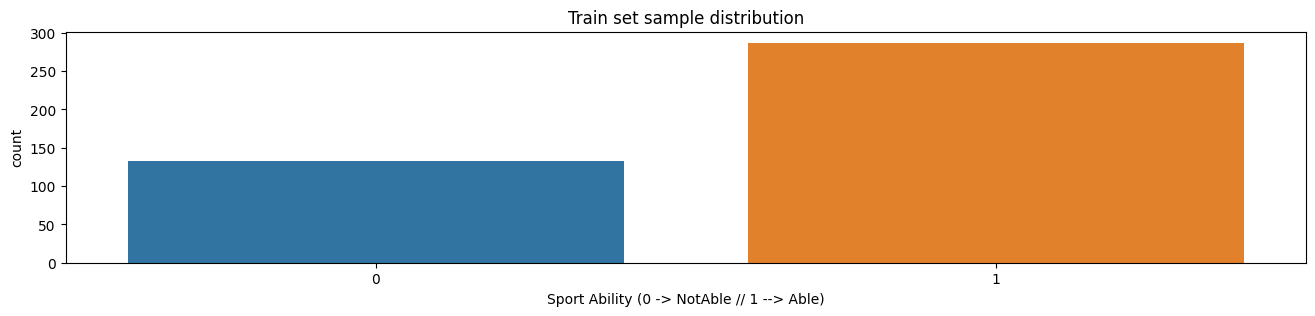

In [18]:
plt.figure(figsize=(16, 3))

sns.countplot(x=tabular_data[TARGET_COL], palette='tab10')

plt.title("Distribuzione classi (tutti i pazienti)")
plt.xlabel("Sport Ability (0 -> NotAble // 1 --> Able)")
plt.show()



## Normalization


In [19]:
# Strutture tabellari base per il K-Fold
tabular_features = tabular_data.drop(columns=[TARGET_COL, ID_COL], errors='ignore').reset_index(drop=True)
labels_series = tabular_data[TARGET_COL].reset_index(drop=True)
print(f"Tabular features shape: {tabular_features.shape}")



In [20]:
# func to normalize signals z-score
def normalize_instance_wise(signals):

    mean = np.mean(signals, axis=1, keepdims=True)
    std = np.std(signals, axis=1, keepdims=True)

    epsilon = 1e-8

    return (signals - mean) / (std + epsilon)

In [21]:
signals_norm = normalize_instance_wise(signals)

print(f"Signals normalized: {signals_norm.shape}")



### Data Augmentation

In [22]:
WINDOW_SIZE = 2500
STRIDE_TRAIN = 250        
STRIDE_VAL = 2500

BATCH_SIZE = 32
JITTER_STRENGTH = 0.15

CHANNEL_MASK = 0.4
N_SPLITS = 5

LEARNING_RATE = 1e-4
EPOCHS = 200
PATIENCE = 50
VERBOSE = 5

# --- Regularization ---
DROPOUT_RATE = 0.5
L1_LAMBDA = 0
L2_LAMBDA = 5e-2
LABEL_SMOOTHING = 0.15

model_dir = "./kfold_models"
os.makedirs(model_dir, exist_ok=True)



In [23]:
def segment_data(signals, tabular, labels, window=WINDOW_SIZE, stride=STRIDE_TRAIN):

    X_sig_seq = []
    X_tab_seq = []
    y_seq = []

    num_patients = signals.shape[0]
    signal_len = signals.shape[1]

    for i in range(num_patients):

        curr_sig = signals[i]
        curr_tab = tabular.iloc[i].values
        curr_label = labels.iloc[i] if hasattr(labels, 'iloc') else labels[i]

        idx = 0
        while idx + window <= signal_len:
            segment = curr_sig[idx : idx + window, :]

            X_sig_seq.append(segment)
            X_tab_seq.append(curr_tab)
            y_seq.append(curr_label)

            idx += stride

    return np.array(X_sig_seq), np.array(X_tab_seq), np.array(y_seq)

# alias to keep previous naming compatibility
build_sequences_numpy = segment_data



In [24]:
# La segmentazione viene ora gestita dentro il ciclo K-Fold con segment_data.



Original Train Patients: 420
Augmented Train Segments: (1260, 2500, 12)
Augmented Tabular Shape: (1260, 14)
Augmented Labels Shape: (1260,)


In [25]:
class ECGThreeBranchDataset(Dataset):
    def __init__(self, signals, tabular, labels=None, is_train=False, JITTER_STRENGTH=0.05, CHANNEL_MASK=0.3):
        """
        signals: (N, 2500, 12) -> splitted in (N, 6, 2500) and (N, 6, 2500)  --> to get 6 leads/6 leads
        """
        self.signals = torch.tensor(signals, dtype=torch.float32).permute(0, 2, 1)
        self.tabular = torch.tensor(tabular, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long) if labels is not None else None

        self.is_train = is_train
        self.jitter_strength = JITTER_STRENGTH
        self.channel_mask_prob = CHANNEL_MASK

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        full_sig = self.signals[idx].clone()

        if self.is_train:

            shift = torch.randint(low=-250, high=250, size=(1,)).item()   #time shifting
            full_sig = torch.roll(full_sig, shifts=shift, dims=1)

            if self.jitter_strength > 0:          # jitter -> put JITTER_STRENGHT = 0 to pass w/
                noise = torch.randn_like(full_sig) * self.jitter_strength
                full_sig = full_sig + noise

            # Channel Masking   --> turn a signal to 0 to prevent model laziness
            if self.channel_mask_prob > 0 and torch.rand(1) < self.channel_mask_prob:
                mask_idx = torch.randint(0, 12, (1,)).item()
                full_sig[mask_idx, :] = 0 
                
        
        # we get 3 dataset --> model needs 3 branch
        # branch 1: Limb Leads (first 6: I, II, III, aVR, aVL, aVF)
        limb_sig = full_sig[:6, :]      # Shape: (6, 2500)

        # Branch 2: Precordial Leads (last  6: V1-V6)
        prec_sig = full_sig[6:, :]      # Shape: (6, 2500)

        # Branch 3: Tabular
        tab_data = self.tabular[idx]

        if self.labels is not None:
            return limb_sig, prec_sig, tab_data, self.labels[idx]
        else:
            return limb_sig, prec_sig, tab_data

In [26]:
def make_loader(ds, batch_size, shuffle, drop_last=False):

    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=2,
    )

In [27]:
def get_scaler(train_df, cols_to_scale=COLS_TO_SCALE):
    scaler = MinMaxScaler()
    scaler.fit(train_df[cols_to_scale])
    return scaler


def process_fold_data(signals, tabular, labels, indices, scaler=None, cols_to_scale=COLS_TO_SCALE):
    sig_subset = signals[indices]
    tab_subset = tabular.iloc[indices].copy()
    label_subset = labels.iloc[indices] if hasattr(labels, 'iloc') else labels[indices]

    if scaler is None:
        scaler = get_scaler(tab_subset, cols_to_scale=cols_to_scale)

    if cols_to_scale:
        tab_subset.loc[:, cols_to_scale] = scaler.transform(tab_subset[cols_to_scale])

    return sig_subset, tab_subset, label_subset, scaler



Dataloaders created!


In [28]:
def create_dataloaders(X_sig, X_tab, y, batch_size=BATCH_SIZE, is_train=False):
    dataset = ECGThreeBranchDataset(
        X_sig, 
        X_tab, 
        y, 
        is_train=is_train,
        JITTER_STRENGTH=JITTER_STRENGTH if is_train else 0,
        CHANNEL_MASK=CHANNEL_MASK if is_train else 0
    )

    shuffle = bool(is_train)
    drop_last = bool(is_train)
    loader = make_loader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
    return loader


def initialize_model(device, n_tab_feats, n_classes, y_train_fold, steps_per_epoch):
    class_weights_array = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_fold),
        y=y_train_fold
    )

    class_weights = torch.tensor(class_weights_array, dtype=torch.float32).to(device)

    model = ThreeBranchSimpleCNN(
        n_tabular_features=n_tab_feats,
        n_classes=n_classes,
        dropout=DROPOUT_RATE
    ).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=LABEL_SMOOTHING)

    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=2e-4,
        steps_per_epoch=max(1, steps_per_epoch),
        epochs=EPOCHS,
        pct_start=0.15,          # 15% epochs LR up, 85% down
        anneal_strategy='cos'
    )

    try:
        scaler = torch.amp.GradScaler(device='cuda', enabled=(device.type == 'cuda'))
    except AttributeError:
        scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))

    return model, criterion, optimizer, scheduler, scaler



--- Batch Shapes ---
Limb Leads Batch:        torch.Size([32, 6, 2500])  -> (Batch, 6, Time)
Precordial Leads Batch:  torch.Size([32, 6, 2500])  -> (Batch, 6, Time)
Tabular Batch:           torch.Size([32, 14])   -> (Batch, Features)
Labels Batch:            torch.Size([32]) -> (Batch)


--- Network Configuration ---
Total Input Channels: 12 (Split into 6 Limb + 6 Precordial)
Input Tabular Features: 14
Number of Classes:      2


In [40]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y

In [41]:

'''
convolution source:
      Cardiologist-level arrhythmia detection and classification in ambulatory electrocardiograms using a deep neural network
      Hannun, A. Y., Rajpurkar, P., Ng, A. Y., et al.
      Nature Medicine (2019)
      Link: Nature Medicine Article | https://arxiv.org/abs/1707.01836
'''

class MicroResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=7, stride=1):
        super(MicroResNetBlock, self).__init__()
        padding = kernel_size // 2
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=1, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.se = SEBlock(out_channels, reduction=4)
        self.shortcut = nn.Sequential()
        if stride > 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)
        out += residual
        out = self.relu(out)
        return out

# Model Building

In [51]:
# 3. Modello Principale a 3 Rami (Aggiornato)
class ThreeBranchSimpleCNN(nn.Module):
    def __init__(self, n_tabular_features, n_classes, dropout=0.5):
        super(ThreeBranchSimpleCNN, self).__init__()

        # Costruttore del ramo ECG completo
        def make_resnet_branch():
            return nn.Sequential(
                # --- INIZIO "GOLDILOCKS" (Largo e conservativo) ---
                # 1. Espansione canali immediata (6 -> 16) e stride=1 per non perdere tempo
                MicroResNetBlock(in_channels=6, out_channels=8, kernel_size=15, stride=1), 
                nn.MaxPool1d(2), # Primo downsampling leggero
                
                # --- CORPO CENTRALE (Approfondimento) ---
                # 2. Aumento canali a 32
                MicroResNetBlock(in_channels=8, out_channels=16, kernel_size=7, stride=2),
                nn.MaxPool1d(2),
                
                # 3. Aumento canali a 64
                MicroResNetBlock(in_channels=16, out_channels=32, kernel_size=5, stride=2),
                                
                # --- CHIUSURA FONDAMENTALE (Mancava questo!) ---
                # Questo layer schiaccia tutta la lunghezza temporale in un solo punto
                # Trasforma (Batch, 128, Lunghezza) -> (Batch, 128, 1)
                nn.AdaptiveAvgPool1d(1) 
            )

        self.branch_limb = make_resnet_branch()
        self.branch_prec = make_resnet_branch()

        self.branch_tab = nn.Sequential(
            nn.Linear(n_tabular_features, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        fusion_dim = 32 + 32 + 16
        
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, n_classes)
        )

    def forward(self, limb, prec, tab):
        # squeeze(-1) ora funziona perché l'ultima dimensione è garantita essere 1 dal pooling
        x_limb = self.branch_limb(limb).squeeze(-1)
        x_prec = self.branch_prec(prec).squeeze(-1)
        x_tab = self.branch_tab(tab)
        
        # Ora sono tutti 2D: (Batch, Features)
        combined = torch.cat([x_limb, x_prec, x_tab], dim=1)
        return self.classifier(combined)

In [52]:
def run_training(model, train_loader, val_loader, criterion, optimizer, scheduler, scaler, device, experiment_name):
    return fit(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=EPOCHS,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        scaler=scaler,
        device=device,
        verbose=VERBOSE,
        experiment_name=experiment_name,
        patience=PATIENCE,
        restore_best_weights=True,
        l1_lambda=L1_LAMBDA,
        l2_lambda=L2_LAMBDA
    )



ThreeBranchSimpleCNN(
  (branch_limb): Sequential(
    (0): MicroResNetBlock(
      (conv1): Conv1d(6, 8, kernel_size=(15,), stride=(1,), padding=(7,), bias=False)
      (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(8, 8, kernel_size=(15,), stride=(1,), padding=(7,), bias=False)
      (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SEBlock(
        (avg_pool): AdaptiveAvgPool1d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=8, out_features=2, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=2, out_features=8, bias=False)
          (3): Sigmoid()
        )
      )
      (shortcut): Sequential(
        (0): Conv1d(6, 8, kernel_size=(1,), stride=(1,), bias=False)
        (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): MaxPool1d(ke

# HYPERPARAMETERS

In [53]:
def predict_and_aggregate(model, loader, segments_per_patient, patient_ids):
    model.eval()
    device = next(model.parameters()).device

    all_probs = []
    all_targets = []

    with torch.no_grad():
        for limb_in, prec_in, tab_in, targets in loader:
            limb_in = limb_in.to(device)
            prec_in = prec_in.to(device)
            tab_in = tab_in.to(device)
            targets = targets.to(device).long()

            logits = model(limb_in, prec_in, tab_in)
            probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
            all_probs.append(probs)
            all_targets.append(targets.cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_targets = np.concatenate(all_targets)

    patient_preds = []
    patient_labels = []
    patient_prob_means = []

    for i, _ in enumerate(patient_ids):
        start_idx = i * segments_per_patient
        end_idx = start_idx + segments_per_patient

        patient_segment_probs = all_probs[start_idx : end_idx]
        patient_segment_labels = all_targets[start_idx : end_idx]

        if len(patient_segment_probs) == 0:
            continue

        avg_prob = float(np.mean(patient_segment_probs))
        pred_label = 1 if avg_prob >= 0.5 else 0

        patient_preds.append(pred_label)
        patient_labels.append(patient_segment_labels[0])
        patient_prob_means.append(avg_prob)

    return np.array(patient_labels), np.array(patient_preds), np.array(patient_prob_means)


def save_fold_results(fold_index, true_labels, pred_labels, history, container):
    fold_f1 = f1_score(true_labels, pred_labels, average='weighted')
    fold_acc = accuracy_score(true_labels, pred_labels)

    container.append({
        "fold": fold_index,
        "f1": fold_f1,
        "accuracy": fold_acc,
        "y_true": true_labels,
        "y_pred": pred_labels,
        "history": history
    })

    print(f"Fold {fold_index} -> F1: {fold_f1:.4f} | Acc: {fold_acc:.4f}")



Wheights: [1.57894737 0.73170732] for classes: [0 1]


## Functions & Main Loop

In [34]:
# train function
def train_one_epoch(model, train_loader, criterion, optimizer, scheduler, scaler, device, l1_lambda=0, l2_lambda=0):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    device_type = 'cuda' if device.type == 'cuda' else 'cpu'

    for limb_in, prec_in, tab_in, targets in train_loader:
        limb_in = limb_in.to(device)
        prec_in = prec_in.to(device)
        tab_in = tab_in.to(device)
        targets = targets.to(device).long()

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type=device_type, enabled=(device.type=='cuda')):
            logits = model(limb_in, prec_in, tab_in)
            loss = criterion(logits, targets)

            # we dont need L1 rn, but here is the logic to make it work  -  L2 already managed by AdamW
            if l1_lambda > 0:
                l1_norm = sum(p.abs().sum() for p in model.parameters() if p.requires_grad)
                loss += l1_lambda * l1_norm


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        if scheduler is not None:
            scheduler.step()

        running_loss += loss.item() * targets.size(0)
        preds = logits.argmax(dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(np.concatenate(all_targets), np.concatenate(all_preds), average='weighted')
    return epoch_loss, epoch_f1

In [35]:
# validate function
def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    device_type = 'cuda' if device.type == 'cuda' else 'cpu'

    with torch.no_grad():
        for limb_in, prec_in, tab_in, targets in val_loader:
            limb_in = limb_in.to(device)
            prec_in = prec_in.to(device)
            tab_in = tab_in.to(device)
            targets = targets.to(device).long()

            with torch.amp.autocast(device_type=device_type, enabled=(device.type=='cuda')):
                logits = model(limb_in, prec_in, tab_in)
                loss = criterion(logits, targets)

            running_loss += loss.item() * targets.size(0)
            preds = logits.argmax(dim=1)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_f1 = f1_score(np.concatenate(all_targets), np.concatenate(all_preds), average='weighted')
    return epoch_loss, epoch_f1

In [36]:

def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scheduler, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, verbose=1, experiment_name="best_model"):

    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Start Training: {epochs} epochs on {device}... \n")
    start_time = time.time()

    for epoch in range(1, epochs + 1):

        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scheduler, scaler, device, l1_lambda, l2_lambda
        )

        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # print
        if verbose > 0 and (epoch % verbose == 0 or epoch == 1):
            current_lr = scheduler.get_last_lr()[0] if scheduler else optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch:3d}/{epochs} | "
                  f"Train Loss: {train_loss:.4f} F1: {train_f1:.4f} | "
                  f"Val Loss: {val_loss:.4f} F1: {val_f1:.4f} | "
                  f"LR: {current_lr:.6f}")

        # early stopping
        if patience > 0:
            current_metric = val_f1 if evaluation_metric == "val_f1" else val_loss

            if mode == 'max':
                is_improvement = current_metric > best_metric
            else:
                is_improvement = current_metric < best_metric

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), f"{model_dir}/{experiment_name}.pt")
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"\nEarly stopping triggered after {epoch} epochs.")
                    break

    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time/60:.2f} minutes.")

    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load(f"{model_dir}/{experiment_name}.pt", map_location=device))
        print(f"Recovered best model: Epoch {best_epoch} with {evaluation_metric}: {best_metric:.4f}")

    return model, training_history

# K-Fold Training


In [37]:
# Il best model viene gestito a livello di fold nel ciclo K-Fold.



In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

fold_results = []

for fold_idx, (train_idx, val_idx) in enumerate(sgkf.split(patient_ids, patient_targets, groups=patient_ids), start=1):
    print(f"
================ Fold {fold_idx}/{N_SPLITS} ===============")

    # --- Split per fold (patient-level) ---
    X_sig_train, X_tab_train, y_train_fold, scaler_tab = process_fold_data(
        signals_norm, tabular_features, labels_series, train_idx
    )
    X_sig_val, X_tab_val, y_val_fold, _ = process_fold_data(
        signals_norm, tabular_features, labels_series, val_idx, scaler=scaler_tab
    )

    # --- Segmentazione ---
    X_sig_train_seq, X_tab_train_seq, y_train_seq = segment_data(
        X_sig_train, X_tab_train, y_train_fold,
        window=WINDOW_SIZE,
        stride=STRIDE_TRAIN
    )
    X_sig_val_seq, X_tab_val_seq, y_val_seq = segment_data(
        X_sig_val, X_tab_val, y_val_fold,
        window=WINDOW_SIZE,
        stride=STRIDE_VAL
    )

    segments_per_patient_val = max(1, 1 + (X_sig_val.shape[1] - WINDOW_SIZE) // STRIDE_VAL)

    # --- Dataloaders ---
    train_loader = create_dataloaders(
        X_sig_train_seq, X_tab_train_seq, y_train_seq,
        batch_size=BATCH_SIZE,
        is_train=True
    )
    val_loader = create_dataloaders(
        X_sig_val_seq, X_tab_val_seq, y_val_seq,
        batch_size=BATCH_SIZE,
        is_train=False
    )

    # --- Model fresh for each fold ---
    model, criterion, optimizer, scheduler, scaler = initialize_model(
        device=device,
        n_tab_feats=X_tab_train_seq.shape[1],
        n_classes=len(np.unique(labels_series)),
        y_train_fold=y_train_seq,
        steps_per_epoch=len(train_loader)
    )

    experiment_name = f"fold_{fold_idx}_ThreeBranchSimpleCNN"

    model, history = run_training(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        scaler=scaler,
        device=device,
        experiment_name=experiment_name
    )

    # --- Validation aggregation per patient ---
    val_true, val_pred, val_prob = predict_and_aggregate(
        model=model,
        loader=val_loader,
        segments_per_patient=segments_per_patient_val,
        patient_ids=patient_ids[val_idx]
    )

    save_fold_results(
        fold_index=fold_idx,
        true_labels=val_true,
        pred_labels=val_pred,
        history=history,
        container=fold_results
    )

    # cleanup fold-specific objects
    del model, optimizer, scheduler, scaler, train_loader, val_loader
    torch.cuda.empty_cache()
    gc.collect()



In [54]:
if not fold_results:
    print("Nessun fold eseguito: esegui il ciclo K-Fold sopra.")
else:
    f1_scores = [fr["f1"] for fr in fold_results]
    acc_scores = [fr["accuracy"] for fr in fold_results]

    print("
================ SUMMARY ================")
    print(f"F1 medio: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
    print(f"Accuracy media: {np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}")



Experiment: ThreeBranchSimpleCNN 
 

Start Training: 500 epochs on cpu... 

Epoch   1/500 | Train Loss: 0.7049 F1: 0.5509 | Val Loss: 0.7047 F1: 0.6294 | LR: 0.000016


KeyboardInterrupt: 

In [ ]:
# Plot history dell'ultimo fold (se presente)
if fold_results:
    last_hist = fold_results[-1]["history"]

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

    ax1.plot(last_hist['train_loss'], label='Training loss', alpha=0.5, color='#1f77b4', linestyle='--')
    ax1.plot(last_hist['val_loss'], label='Validation loss', alpha=1.0, color='#1f77b4')
    ax1.set_title('Loss Evolution')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(alpha=0.3)

    ax2.plot(last_hist['train_f1'], label='Training F1', alpha=0.5, color='#ff7f0e', linestyle='--')
    ax2.plot(last_hist['val_f1'], label='Validation F1', alpha=1.0, color='#ff7f0e')
    ax2.set_title('F1 Score Evolution')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('F1 Score')
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()



## Inference


In [46]:
torch.cuda.empty_cache()
gc.collect()
print("Pulizia GPU e RAM completata.")



Best model loaded successfully.


IOStream.flush timed out


In [66]:
# Inference handled fold-by-fold. No separate test step defined in this notebook version.



Total Segments Predicted: 106


In [68]:
# Soft voting aggregation handled inside predict_and_aggregate during each fold.



Aggregating predictions: 2 segments per patient. 

   ECG_patient_id  True_Label_Code  Pred_Label_Code  Is_Correct
0             413                0                0        True
1             529                0                0        True
2             549                1                0       False
3             269                0                0        True
4             484                1                0       False
5             512                0                0        True
6             426                0                0        True
7             378                0                0        True
8             495                0                0        True
9             338                0                0        True



         FINAL REPORT
              precision    recall  f1-score   support

     Class_0       0.68      0.76      0.72        17
     Class_1       0.88      0.83      0.86        36

    accuracy                           0.81        53
  

In [49]:
# Bootstrapping section skipped for the K-Fold workflow.



Calculating stability on 53 patients using Bootstrapping (5000 iterations)...

 MODEL STABILITY (95% Confidence Interval)
Mean F1-Score: 0.8115
F1 Interval:  [0.6981 - 0.9080]
----------------------------------------
❌ ASSESSMENT: The model is UNSTABLE


#FINE ---> fare k fold sicuramnete / sistemare il preprocessing da controllare, non so se è corretto e va bene

----------------------------------------------------------------------------------------------------------------------------------------------------------------